In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *

In [2]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'HIDDEN')

In [12]:
results = search_images_bing(key, 'wasp')

In [13]:
ims = results.attrgot('contentUrl')

In [14]:
insect = 'wasp', 'bee'

In [15]:
path = Path('insect')

In [16]:
if not path.exists():
    path.mkdir()
    for types in insect:
        dest = (path/types)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{types}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [17]:
fns = get_image_files(path)

In [18]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [34]:
insect = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [35]:
dls = insect.dataloaders(path)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


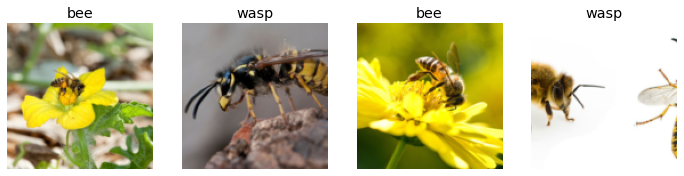

In [36]:
dls.valid.show_batch(max_n=4, nrows=1)

In [37]:
insect = insect.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = insect.dataloaders(path)

In [38]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.305036,0.730084,0.324324,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.595209,0.307657,0.162162,00:05
1,0.419520,0.113617,0.054054,00:05
2,0.300050,0.101316,0.027027,00:05
3,0.242719,0.113284,0.027027,00:05


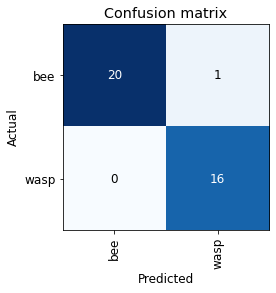

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

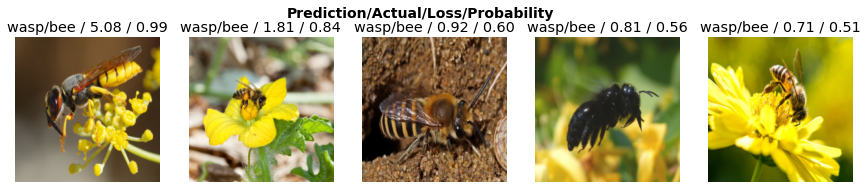

In [26]:
interp.plot_top_losses(5, nrows=1)

In [29]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [33]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [40]:
learn.export()

In [8]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [9]:
learn_inf = load_learner(path/'export.pkl')

In [10]:
btn_upload = widgets.FileUpload()

btn_upload = SimpleNamespace(data = ['insect/bee/00000000.jpg'])
img = PILImage.create(btn_upload.data[-1])

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run = widgets.Button(description='Classify')


In [11]:
def on_click_classify(change):
    if btn_upload._counter == 0:
        print('Please upload an image first !')
    else:
        img = PILImage.create(btn_upload.data[-1])
        out_pl.clear_output()
        with out_pl: display(img.to_thumb(128,128))
        pred,pred_idx,probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

btn_upload = widgets.FileUpload()

In [12]:
VBox([widgets.Label('Please show me your flying thingy.'), 
      btn_upload, btn_run, out_pl, lbl_pred])